<a href="https://colab.research.google.com/github/anaellez/Dynamic-Hybrid-Chatbots-Learning-When-to-Rely-on-Intent-Recognition-or-Direct-Generation/blob/main/dynamic_hybrid_chatbot_routing_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import transformers
print(transformers.__version__)


4.57.3


In [ ]:
!pip -q install -U transformers datasets accelerate evaluate sacrebleu sentencepiece scikit-learn joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 15.1 MB/s eta 0:00:00


In [ ]:
import os, json
import numpy as np
import torch
import transformers
import evaluate
import joblib

from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, DataCollatorWithPadding,
    T5Tokenizer, T5ForConditionalGeneration,
    Seq2SeqTrainingArguments, Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("transformers:", transformers.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA:", torch.cuda.is_available(), "| device:", device)

# SAFE import for TrainingArguments (avoids weird shadowing)
TrainingArguments = transformers.TrainingArguments

transformers: 4.57.3
CUDA: True | device: cuda


In [ ]:
# =========================================
# CELL 2: Load dataset + Clean
# =========================================
dataset = load_dataset("bitext/Bitext-customer-support-llm-chatbot-training-dataset")

remove_cols = [c for c in ["flags", "category"] if c in dataset["train"].column_names]
if remove_cols:
    dataset = dataset.remove_columns(remove_cols)

full = dataset["train"]
print("Columns:", full.column_names)
print("Total samples:", len(full))
print("Example:", full[0])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Bitext_Sample_Customer_Support_Training_(…):   0%|          | 0.00/19.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/26872 [00:00<?, ? examples/s]

Columns: ['instruction', 'intent', 'response']
Total samples: 26872
Example: {'instruction': 'question about cancelling order {{Order Number}}', 'intent': 'cancel_order', 'response': "I've understood you have a question regarding canceling order {{Order Number}}, and I'm here to provide you with the information you need. Please go ahead and ask your question, and I'll do my best to assist you."}


In [ ]:
# =========================================
# CELL 3: Split train/val/meta_dev/eval
# 70% train_full, 30% temp
# temp -> 50/50 => meta_dev, eval
# train_full -> 90/10 => train, val
# =========================================
split_main = full.train_test_split(test_size=0.30, seed=42)
train_full = split_main["train"]
temp = split_main["test"]

split_temp = temp.train_test_split(test_size=0.5, seed=42)
meta_dev = split_temp["train"]
eval_ds = split_temp["test"]

split_base = train_full.train_test_split(test_size=0.1, seed=42)
train_ds = split_base["train"]
val_ds = split_base["test"]

data_splits = DatasetDict({
    "train": train_ds,
    "val": val_ds,
    "meta_dev": meta_dev,
    "eval": eval_ds
})

print("train:", len(data_splits["train"]))
print("val:", len(data_splits["val"]))
print("meta_dev:", len(data_splits["meta_dev"]))
print("eval:", len(data_splits["eval"]))


train: 16929
val: 1881
meta_dev: 4031
eval: 4031


In [ ]:
# =========================================
# CELL 4: Label mapping for intent (from TRAIN only)
# =========================================
intents = sorted(list(set(data_splits["train"]["intent"])))
label2id = {lbl: i for i, lbl in enumerate(intents)}
id2label = {i: lbl for lbl, i in label2id.items()}

print("Number of intents:", len(intents))
print("label2id sample:", list(label2id.items())[:10])

# sanity check
unseen_val = set(data_splits["val"]["intent"]) - set(intents)
unseen_eval = set(data_splits["eval"]["intent"]) - set(intents)
print("Unseen intents in val:", unseen_val)
print("Unseen intents in eval:", unseen_eval)

def add_label(ex):
    ex["label"] = label2id[ex["intent"]]
    return ex

for split in ["train", "val", "meta_dev", "eval"]:
    data_splits[split] = data_splits[split].map(add_label)


Number of intents: 27
label2id sample: [('cancel_order', 0), ('change_order', 1), ('change_shipping_address', 2), ('check_cancellation_fee', 3), ('check_invoice', 4), ('check_payment_methods', 5), ('check_refund_policy', 6), ('complaint', 7), ('contact_customer_service', 8), ('contact_human_agent', 9)]
Unseen intents in val: set()
Unseen intents in eval: set()


Map:   0%|          | 0/16929 [00:00<?, ? examples/s]

Map:   0%|          | 0/1881 [00:00<?, ? examples/s]

Map:   0%|          | 0/4031 [00:00<?, ? examples/s]

Map:   0%|          | 0/4031 [00:00<?, ? examples/s]

In [ ]:
# =========================================
# CELL 5: Tokenize for BERT
# =========================================
bert_name = "bert-base-uncased"
bert_tok = AutoTokenizer.from_pretrained(bert_name)
MAX_LEN_BERT = 128

def tok_bert(batch):
    return bert_tok(batch["instruction"], truncation=True, max_length=MAX_LEN_BERT)

tokenized_bert = data_splits.map(tok_bert, batched=True)

# remove text columns from tokenized
text_cols = [c for c in ["instruction", "intent", "response"] if c in tokenized_bert["train"].column_names]
for split in ["train", "val", "meta_dev", "eval"]:
    tokenized_bert[split] = tokenized_bert[split].remove_columns(text_cols)
    tokenized_bert[split].set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

bert_collator = DataCollatorWithPadding(tokenizer=bert_tok)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/16929 [00:00<?, ? examples/s]

Map:   0%|          | 0/1881 [00:00<?, ? examples/s]

Map:   0%|          | 0/4031 [00:00<?, ? examples/s]

Map:   0%|          | 0/4031 [00:00<?, ? examples/s]

In [ ]:
# =========================================
# CELL 6: Train BERT Intent Classifier
# =========================================
bert_model = AutoModelForSequenceClassification.from_pretrained(
    bert_name,
    num_labels=len(intents),
    id2label=id2label,
    label2id=label2id
).to(device)

acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics_intent(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = acc_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1m = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"accuracy": acc, "f1_macro": f1m}

bert_args = TrainingArguments(
    output_dir="./bert_intent",
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    max_steps=2000,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)


bert_trainer = Trainer(
    model=bert_model,
    args=bert_args,
    train_dataset=tokenized_bert["train"],
    eval_dataset=tokenized_bert["val"],
    tokenizer=bert_tok,
    data_collator=bert_collator,
    compute_metrics=compute_metrics_intent
)

bert_trainer.train()
print("VAL:", bert_trainer.evaluate(tokenized_bert["val"]))
print("EVAL:", bert_trainer.evaluate(tokenized_bert["eval"]))

bert_best_dir = "./bert_intent_best"
bert_trainer.save_model(bert_best_dir)
bert_tok.save_pretrained(bert_best_dir)
print("Saved BERT to:", bert_best_dir)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2577119729.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  bert_trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1 Macro
500,0.174300,0.112543,0.991494,0.991592
1000,0.026100,0.024121,0.996279,0.996454
1500,0.019100,0.020092,0.995215,0.995426
2000,0.014300,0.018913,0.996810,0.996995


VAL: {'eval_loss': 0.018913155421614647, 'eval_accuracy': 0.9968102073365231, 'eval_f1_macro': 0.996994779318235, 'eval_runtime': 16.8827, 'eval_samples_per_second': 111.416, 'eval_steps_per_second': 55.738, 'epoch': 1.8893089190785588}
EVAL: {'eval_loss': 0.01934037357568741, 'eval_accuracy': 0.996774993798065, 'eval_f1_macro': 0.9967361486286668, 'eval_runtime': 25.8409, 'eval_samples_per_second': 155.993, 'eval_steps_per_second': 78.016, 'epoch': 1.8893089190785588}
Saved BERT to: ./bert_intent_best


In [ ]:
# =========================================
# CELL 7: Predict intent helper (batch)
# =========================================
@torch.no_grad()
def predict_intents(texts, batch_size=64):
    bert_model.eval()
    out = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = bert_tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN_BERT).to(device)
        logits = bert_model(**enc).logits
        pred_ids = torch.argmax(logits, dim=-1).cpu().tolist()
        out.extend([id2label[j] for j in pred_ids])
    return out

demo = "I want to reset my password but I can't access my email"
print("Demo intent:", predict_intents([demo])[0])


Demo intent: recover_password


In [ ]:
# =========================================
# CELL 8: T5 SIMPLE training (instruction -> response)
# =========================================
t5_name = "t5-small"
t5_tok = T5Tokenizer.from_pretrained(t5_name)
t5_simple_model = T5ForConditionalGeneration.from_pretrained(t5_name).to(device)

MAX_IN_SIMPLE = 128
MAX_OUT_SIMPLE = 128

def preprocess_t5_simple(batch):
    inputs = batch["instruction"]
    targets = batch["response"]

    model_inputs = t5_tok(inputs, max_length=MAX_IN_SIMPLE, truncation=True, padding="max_length")
    labels = t5_tok(text_target=targets, max_length=MAX_OUT_SIMPLE, truncation=True, padding="max_length")["input_ids"]
    labels = [[tok if tok != t5_tok.pad_token_id else -100 for tok in seq] for seq in labels]

    model_inputs["labels"] = labels
    return model_inputs

t5_simple_train = data_splits["train"].map(preprocess_t5_simple, batched=True, remove_columns=data_splits["train"].column_names)
t5_simple_val   = data_splits["val"].map(preprocess_t5_simple, batched=True, remove_columns=data_splits["val"].column_names)
t5_simple_train.set_format(type="torch")
t5_simple_val.set_format(type="torch")

bleu_metric = evaluate.load("sacrebleu")

def compute_bleu(eval_pred):
    preds, labels = eval_pred
    pred_text = t5_tok.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, t5_tok.pad_token_id)
    label_text = t5_tok.batch_decode(labels, skip_special_tokens=True)
    score = bleu_metric.compute(predictions=pred_text, references=[[t] for t in label_text])["score"]
    return {"bleu": score}

simple_args = Seq2SeqTrainingArguments(
    output_dir="./t5_simple",
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    learning_rate=3e-4,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    max_steps=800,
    predict_with_generate=True,
    logging_steps=50,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True
)

t5_collator_simple = DataCollatorForSeq2Seq(tokenizer=t5_tok, model=t5_simple_model)

simple_trainer = Seq2SeqTrainer(
    model=t5_simple_model,
    args=simple_args,
    train_dataset=t5_simple_train,
    eval_dataset=t5_simple_val,
    tokenizer=t5_tok,
    data_collator=t5_collator_simple,
    compute_metrics=compute_bleu
)

simple_trainer.train()

t5_simple_best_dir = "./t5_simple_best"
simple_trainer.save_model(t5_simple_best_dir)
t5_tok.save_pretrained(t5_simple_best_dir)
print("Saved:", t5_simple_best_dir)


Map:   0%|          | 0/16929 [00:00<?, ? examples/s]

Map:   0%|          | 0/1881 [00:00<?, ? examples/s]

/tmp/ipython-input-3518392905.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  simple_trainer = Seq2SeqTrainer(
/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss,Validation Loss,Bleu
200,1.862800,1.560396,0.261079
400,1.642600,1.378442,0.263565
600,1.573100,1.300250,0.261775


Step,Training Loss,Validation Loss,Bleu
200,1.862800,1.560396,0.261079
400,1.642600,1.378442,0.263565
600,1.573100,1.300250,0.261775
800,1.521400,1.277321,0.261786


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Saved: ./t5_simple_best


In [ ]:
# =========================================
# CELL 9: Add intent_pred to all splits
# =========================================
def add_intent_pred(batch):
    texts = batch["instruction"]
    batch["intent_pred"] = predict_intents(texts, batch_size=64)
    return batch

train_i    = data_splits["train"].map(add_intent_pred, batched=True, batch_size=64)
val_i      = data_splits["val"].map(add_intent_pred, batched=True, batch_size=64)
meta_dev_i = data_splits["meta_dev"].map(add_intent_pred, batched=True, batch_size=64)
eval_i     = data_splits["eval"].map(add_intent_pred, batched=True, batch_size=64)

print("Example with intent_pred:", meta_dev_i[0])


Map:   0%|          | 0/16929 [00:00<?, ? examples/s]

Map:   0%|          | 0/1881 [00:00<?, ? examples/s]

Map:   0%|          | 0/4031 [00:00<?, ? examples/s]

Map:   0%|          | 0/4031 [00:00<?, ? examples/s]

Example with intent_pred: {'instruction': 'help switching an article of order {{Order Number}}', 'intent': 'change_order', 'response': 'Thank you for reaching out to us with your request to switch an article in order number #{{Order Number}}. We understand that sometimes changes are needed to ensure your complete satisfaction with your purchase. In order to assist you with this, could you please provide us with the details of the article you would like to switch and the replacement article you have in mind? This way, we can work together to find the best solution for you. We appreciate your patience and cooperation as we strive to make your shopping experience exceptional.', 'label': 1, 'intent_pred': 'change_order'}


In [ ]:
# =========================================
# CELL 10: T5 COMPLEX training (intent_pred + instruction -> response)
# =========================================
t5_complex_model = T5ForConditionalGeneration.from_pretrained(t5_name).to(device)

MAX_IN_COMPLEX = 256
MAX_OUT_COMPLEX = 256

def preprocess_t5_complex(batch):
    inputs = [f"intent: {ip} | {ins}" for ip, ins in zip(batch["intent_pred"], batch["instruction"])]
    targets = batch["response"]

    model_inputs = t5_tok(inputs, max_length=MAX_IN_COMPLEX, truncation=True, padding="max_length")
    labels = t5_tok(text_target=targets, max_length=MAX_OUT_COMPLEX, truncation=True, padding="max_length")["input_ids"]
    labels = [[tok if tok != t5_tok.pad_token_id else -100 for tok in seq] for seq in labels]

    model_inputs["labels"] = labels
    return model_inputs

t5_complex_train = train_i.map(preprocess_t5_complex, batched=True, remove_columns=train_i.column_names)
t5_complex_val   = val_i.map(preprocess_t5_complex, batched=True, remove_columns=val_i.column_names)
t5_complex_train.set_format(type="torch")
t5_complex_val.set_format(type="torch")

complex_args = Seq2SeqTrainingArguments(
    output_dir="./t5_complex",
    eval_strategy="steps",
    eval_steps=200,
    save_steps=200,
    learning_rate=3e-4,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    max_steps=800,
    predict_with_generate=True,
    logging_steps=50,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True
)


t5_collator_complex = DataCollatorForSeq2Seq(tokenizer=t5_tok, model=t5_complex_model)

complex_trainer = Seq2SeqTrainer(
    model=t5_complex_model,
    args=complex_args,
    train_dataset=t5_complex_train,
    eval_dataset=t5_complex_val,
    tokenizer=t5_tok,
    data_collator=t5_collator_complex,
    compute_metrics=compute_bleu
)

complex_trainer.train()

t5_complex_best_dir = "./t5_complex_best"
complex_trainer.save_model(t5_complex_best_dir)
t5_tok.save_pretrained(t5_complex_best_dir)
print("Saved:", t5_complex_best_dir)


Map:   0%|          | 0/16929 [00:00<?, ? examples/s]

Map:   0%|          | 0/1881 [00:00<?, ? examples/s]

/tmp/ipython-input-3046800987.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  complex_trainer = Seq2SeqTrainer(


Step,Training Loss,Validation Loss,Bleu
200,1.866300,1.571574,0.069900
400,1.636200,1.371924,0.068543
600,1.563400,1.297364,0.072459
800,1.512600,1.271715,0.068128


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Saved: ./t5_complex_best


In [ ]:
# =========================================
# CELL 11: Load best T5 models + generation helpers
# =========================================
t5_simple = T5ForConditionalGeneration.from_pretrained(t5_simple_best_dir).to(device).eval()
t5_complex = T5ForConditionalGeneration.from_pretrained(t5_complex_best_dir).to(device).eval()

@torch.no_grad()
def generate_simple(texts, max_new_tokens=64):
    enc = t5_tok(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    outs = t5_simple.generate(**enc, max_new_tokens=max_new_tokens)
    return t5_tok.batch_decode(outs, skip_special_tokens=True)

@torch.no_grad()
def generate_complex(intent_preds, texts, max_new_tokens=64):
    inputs = [f"intent: {i} | {t}" for i, t in zip(intent_preds, texts)]
    enc = t5_tok(inputs, padding=True, truncation=True, return_tensors="pt").to(device)
    outs = t5_complex.generate(**enc, max_new_tokens=max_new_tokens)
    return t5_tok.batch_decode(outs, skip_special_tokens=True)


In [ ]:
# =========================================
# CELL 12: Meta-dev labeling using per-example BLEU
# =========================================
def label_meta_dev(batch):
    texts = batch["instruction"]
    refs = batch["response"]
    intents_pred = batch["intent_pred"]

    ps = generate_simple(texts)
    pc = generate_complex(intents_pred, texts)

    labels = []
    for s, c, r in zip(ps, pc, refs):
        bs = bleu_metric.compute(predictions=[s], references=[[r]])["score"]
        bc = bleu_metric.compute(predictions=[c], references=[[r]])["score"]
        labels.append("complex" if bc > bs else "simple")

    batch["route_label"] = labels
    return batch

meta_labeled = meta_dev_i.map(label_meta_dev, batched=True, batch_size=8)

from collections import Counter
print("Route label distribution:", Counter(meta_labeled["route_label"]))
print("Example:", meta_labeled[0])


Parameter 'function'=<function label_meta_dev at 0x7e3b67513c40> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only shown once. Subsequent hashing failures won't be shown.


Map:   0%|          | 0/4031 [00:00<?, ? examples/s]

Route label distribution: Counter({'complex': 2562, 'simple': 1469})
Example: {'instruction': 'help switching an article of order {{Order Number}}', 'intent': 'change_order', 'response': 'Thank you for reaching out to us with your request to switch an article in order number #{{Order Number}}. We understand that sometimes changes are needed to ensure your complete satisfaction with your purchase. In order to assist you with this, could you please provide us with the details of the article you would like to switch and the replacement article you have in mind? This way, we can work together to find the best solution for you. We appreciate your patience and cooperation as we strive to make your shopping experience exceptional.', 'label': 1, 'intent_pred': 'change_order', 'route_label': 'complex'}


In [ ]:
# =========================================
# CELL 13: Router features from BERT uncertainty
# =========================================
@torch.no_grad()
def add_router_features(batch):
    texts = batch["instruction"]
    enc = bert_tok(texts, padding=True, truncation=True, max_length=MAX_LEN_BERT, return_tensors="pt").to(device)
    logits = bert_model(**enc).logits
    probs = torch.softmax(logits, dim=-1).cpu().numpy()

    conf = probs.max(axis=1)
    top2 = np.sort(probs, axis=1)[:, -2:]
    margin = top2[:, 1] - top2[:, 0]
    entropy = -(probs * np.log(probs + 1e-12)).sum(axis=1)
    lengths = [len(bert_tok(t)["input_ids"]) for t in texts]

    batch["feat_conf"] = conf.tolist()
    batch["feat_margin"] = margin.tolist()
    batch["feat_entropy"] = entropy.tolist()
    batch["feat_len"] = lengths
    batch["y"] = [1 if lbl == "complex" else 0 for lbl in batch["route_label"]]
    return batch

meta_feat = meta_labeled.map(add_router_features, batched=True, batch_size=64)

X = np.column_stack([
    meta_feat["feat_conf"],
    meta_feat["feat_margin"],
    meta_feat["feat_entropy"],
    meta_feat["feat_len"]
])
y = np.array(meta_feat["y"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

router = LogisticRegression(max_iter=2000)
router.fit(X_train, y_train)

pred = router.predict(X_test)
print(classification_report(y_test, pred, target_names=["simple","complex"]))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))

joblib.dump(router, "./router_lr.joblib")
print("Saved: ./router_lr.joblib")


Map:   0%|          | 0/4031 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

      simple       0.00      0.00      0.00       294
     complex       0.64      1.00      0.78       513

    accuracy                           0.64       807
   macro avg       0.32      0.50      0.39       807
weighted avg       0.40      0.64      0.49       807

Confusion matrix:
 [[  0 294]
 [  0 513]]
Saved: ./router_lr.joblib


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
# =========================================
# CELL 14: Threshold tuning + save/load
# =========================================
probs = router.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.4, 0.7, 301)
best_t = None
best_score = -1

for t in thresholds:
    pred_t = (probs > t).astype(int)
    rate = pred_t.mean()
    if not (0.05 < rate < 0.95):
        continue
    score = f1_score(y_test, pred_t, average="macro")
    if score > best_score:
        best_score = score
        best_t = float(t)

THRESHOLD = float(best_t)
print("Best threshold:", round(THRESHOLD, 3))
print("Best macro-F1:", round(best_score, 3))
print("Complex rate:", round(((probs > THRESHOLD).astype(int)).mean(), 3))

with open("./router_threshold.json", "w") as f:
    json.dump({"threshold": THRESHOLD}, f)
print("Saved threshold to ./router_threshold.json")

with open("./router_threshold.json") as f:
    THRESHOLD = json.load(f)["threshold"]
print("Using THRESHOLD =", THRESHOLD)


Best threshold: 0.637
Best macro-F1: 0.527
Complex rate: 0.545
Saved threshold to ./router_threshold.json
Using THRESHOLD = 0.637


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

pred_best = (probs > THRESHOLD).astype(int)
print(classification_report(y_test, pred_best, target_names=["simple","complex"]))
print(confusion_matrix(y_test, pred_best))


              precision    recall  f1-score   support

      simple       0.40      0.50      0.44       294
     complex       0.66      0.57      0.61       513

    accuracy                           0.54       807
   macro avg       0.53      0.53      0.53       807
weighted avg       0.57      0.54      0.55       807

[[146 148]
 [221 292]]


In [ ]:
# =========================================
# CELL 15: Apply router to EVAL + demo outputs
# =========================================
@torch.no_grad()
def build_router_features(texts):
    enc = bert_tok(texts, padding=True, truncation=True, max_length=MAX_LEN_BERT, return_tensors="pt").to(device)
    logits = bert_model(**enc).logits
    probs_ = torch.softmax(logits, dim=-1).cpu().numpy()
    conf_ = probs_.max(axis=1)
    top2_ = np.sort(probs_, axis=1)[:, -2:]
    margin_ = top2_[:, 1] - top2_[:, 0]
    entropy_ = -(probs_ * np.log(probs_ + 1e-12)).sum(axis=1)
    len_ = np.array([len(bert_tok(t)["input_ids"]) for t in texts])
    return np.column_stack([conf_, margin_, entropy_, len_])

eval_texts = list(eval_i["instruction"])

X_eval = build_router_features(eval_texts)

probs_eval = router.predict_proba(X_eval)[:, 1]
route_eval = (probs_eval > THRESHOLD).astype(int)  # 1=complex, 0=simple
print("Complex rate on EVAL:", route_eval.mean())

# show a few examples
idxs = list(range(5))
sample_texts = [eval_texts[i] for i in idxs]
sample_intents = [eval_i["intent_pred"][i] for i in idxs]

pred_s = generate_simple(sample_texts)
pred_c = generate_complex(sample_intents, sample_texts)

for k, i in enumerate(idxs):
    r = "complex" if route_eval[i] == 1 else "simple"
    print("\n---")
    print("Q:", sample_texts[k])
    print("intent_pred:", sample_intents[k])
    print("route:", r)
    print("simple:", pred_s[k])
    print("complex:", pred_c[k])



Complex rate on EVAL: 0.5102952121061771

---
Q: assistance restoring the access key of my profile
intent_pred: recover_password
route: complex
simple: I'm here to assist you in restoring the access key of your profile. To restore your access key, please follow these steps: 1. Log in to your account on our website. 2. Navigate to the "My Account" or "Profile" section. 3. Look for the "Account Settings" or "
complex: I'm here to assist you in restoring the access key of your profile. To proceed with the restore, please follow these steps: 1. Log in to your profile on our website. 2. Navigate to the "Profile Recovery" or "Profile Recovery". 3. Look for the option to

---
Q: see the status of the reimbursement
intent_pred: track_refund
route: complex
simple: I'm here to assist you in checking the status of your reimbursement. To assist you further, could you please provide me with the specific details of your reimbursement? This will allow me to provide you with the most accurate informat

In [ ]:
import numpy as np
import torch

def safe_text_list(x):
    # converts HF datasets column / np arrays to pure python list[str]
    if x is None:
        return []
    if not isinstance(x, list):
        x = list(x)
    # ensure strings
    x = ["" if t is None else str(t) for t in x]
    return x

@torch.no_grad()
def build_router_features(texts, bert_tok, bert_model, device, max_len=128, batch_size=64):
    texts = safe_text_list(texts)
    feats = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = bert_tok(
            batch,
            padding=True,
            truncation=True,
            max_length=max_len,
            return_tensors="pt"
        ).to(device)

        logits = bert_model(**enc).logits  # [B, num_labels]
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()

        conf = probs.max(axis=1)  # max prob
        top2 = np.sort(probs, axis=1)[:, -2:]
        margin = top2[:, 1] - top2[:, 0]
        entropy = -(probs * np.log(probs + 1e-12)).sum(axis=1)

        # token length of each text (approx, not padded)
        lens = np.array([len(bert_tok(t)["input_ids"]) for t in batch])

        feats.append(np.column_stack([conf, margin, entropy, lens]))

    return np.vstack(feats) if len(feats) else np.zeros((0, 4), dtype=float)

def route_with_threshold(router, X, threshold):
    probs = router.predict_proba(X)[:, 1]  # P(complex)
    route = (probs > float(threshold)).astype(int)  # 1=complex,0=simple
    return probs, route


In [ ]:
import numpy as np

eval_texts = safe_text_list(eval_i["instruction"])
X_eval = build_router_features(eval_texts, bert_tok, bert_model, device, max_len=128, batch_size=64)

probs_eval, route_eval = route_with_threshold(router, X_eval, THRESHOLD)

print("EVAL size:", len(eval_texts))
print("Threshold:", THRESHOLD)
print("Complex rate:", round(route_eval.mean(), 3))

print("\nProbability summary (P(complex)):")
print(" min:", round(float(probs_eval.min()), 3),
      " p25:", round(float(np.quantile(probs_eval, 0.25)), 3),
      " median:", round(float(np.median(probs_eval)), 3),
      " p75:", round(float(np.quantile(probs_eval, 0.75)), 3),
      " max:", round(float(probs_eval.max()), 3))

# sanity: are we in a non-degenerate regime?
if route_eval.mean() < 0.05 or route_eval.mean() > 0.95:
    print("\n⚠️ WARNING: routing is near-degenerate (almost all one side). Consider re-tuning threshold.")
else:
    print("\n✅ Routing is non-degenerate (balanced enough).")


EVAL size: 4031
Threshold: 0.637
Complex rate: 0.51

Probability summary (P(complex)):
 min: 0.249  p25: 0.628  median: 0.637  p75: 0.645  max: 0.67

✅ Routing is non-degenerate (balanced enough).


לכל intent:

כמה אחוז מהשאילתות נשלחות ל-complex

In [ ]:
from collections import Counter, defaultdict
import numpy as np

eval_intents = safe_text_list(eval_i["intent_pred"])

# guard: lengths must match
n = min(len(eval_intents), len(route_eval))
eval_intents = eval_intents[:n]
route_eval_ = route_eval[:n]

counts = Counter(eval_intents)
rates = defaultdict(list)

for intent, r in zip(eval_intents, route_eval_):
    rates[intent].append(int(r))

# build a sorted table (top intents by frequency)
rows = []
for intent, c in counts.most_common(30):
    cr = float(np.mean(rates[intent]))
    rows.append((intent, c, cr))

print("Top intents (by frequency) + Complex rate:")
for intent, c, cr in rows:
    print(f"{intent:30s} | n={c:4d} | complex_rate={cr:.3f}")


Top intents (by frequency) + Complex rate:
contact_human_agent            | n= 174 | complex_rate=0.776
track_refund                   | n= 170 | complex_rate=0.188
place_order                    | n= 158 | complex_rate=0.778
switch_account                 | n= 156 | complex_rate=0.468
newsletter_subscription        | n= 156 | complex_rate=0.494
recover_password               | n= 155 | complex_rate=0.548
check_invoice                  | n= 153 | complex_rate=0.196
get_refund                     | n= 152 | complex_rate=0.474
check_payment_methods          | n= 152 | complex_rate=0.612
delivery_options               | n= 152 | complex_rate=0.461
review                         | n= 150 | complex_rate=0.527
payment_issue                  | n= 150 | complex_rate=0.580
edit_account                   | n= 149 | complex_rate=0.738
get_invoice                    | n= 148 | complex_rate=0.115
cancel_order                   | n= 148 | complex_rate=0.277
create_account                 | n= 147 | 

In [ ]:
import numpy as np

# X_eval columns: [conf, margin, entropy, len]
conf, margin, entropy, length = X_eval[:,0], X_eval[:,1], X_eval[:,2], X_eval[:,3]

def summarize(name, arr, mask):
    a = arr[mask]
    if len(a) == 0:
        print(name, "EMPTY")
        return
    print(f"{name:10s} | mean={a.mean():.4f}  median={np.median(a):.4f}  p25={np.quantile(a,0.25):.4f}  p75={np.quantile(a,0.75):.4f}")

mask_c = (route_eval == 1)
mask_s = (route_eval == 0)

print("=== Feature stats by routed class ===")
print("\n--- SIMPLE (routed) ---")
summarize("conf", conf, mask_s)
summarize("margin", margin, mask_s)
summarize("entropy", entropy, mask_s)
summarize("len", length, mask_s)

print("\n--- COMPLEX (routed) ---")
summarize("conf", conf, mask_c)
summarize("margin", margin, mask_c)
summarize("entropy", entropy, mask_c)
summarize("len", length, mask_c)

print("\nExpected trends (good sign):")
print("- complex: higher entropy, lower margin/conf, longer length (often).")


=== Feature stats by routed class ===

--- SIMPLE (routed) ---
conf       | mean=0.9917  median=0.9940  p25=0.9933  p75=0.9945
margin     | mean=0.9898  median=0.9933  p25=0.9924  p75=0.9940
entropy    | mean=0.0635  median=0.0550  p25=0.0506  p75=0.0596
len        | mean=15.7999  median=15.0000  p25=14.0000  p75=17.0000

--- COMPLEX (routed) ---
conf       | mean=0.9939  median=0.9943  p25=0.9934  p75=0.9946
margin     | mean=0.9932  median=0.9937  p25=0.9925  p75=0.9941
entropy    | mean=0.0557  median=0.0529  p25=0.0499  p75=0.0596
len        | mean=10.2183  median=11.0000  p25=9.0000  p75=12.0000

Expected trends (good sign):
- complex: higher entropy, lower margin/conf, longer length (often).


מסקנה נכונה

Routing is influenced by higher-level semantic signals beyond token-level uncertainty.

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# assumes you have X_test, y_test from router split
probs_test = router.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.3, 0.9, 61)
curve = []

for t in thresholds:
    pred = (probs_test > t).astype(int)
    rate = pred.mean()
    # macro-F1 gives equal weight to both classes
    f1m = f1_score(y_test, pred, average="macro")
    curve.append((t, rate, f1m))

# print best by macro-F1 but keep non-degenerate routing
curve_nd = [x for x in curve if 0.05 < x[1] < 0.95]
best = max(curve_nd, key=lambda x: x[2])

print("Best (non-degenerate) threshold by macro-F1:")
print("t =", round(best[0], 3), "| complex_rate =", round(best[1], 3), "| macroF1 =", round(best[2], 3))

print("\nSample points:")
for t, rate, f1m in curve[::10]:
    print("t=", round(t,3), " rate=", round(rate,3), " macroF1=", round(f1m,3))


Best (non-degenerate) threshold by macro-F1:
t = 0.64 | complex_rate = 0.425 | macroF1 = 0.522

Sample points:
t= 0.3  rate= 1.0  macroF1= 0.389
t= 0.4  rate= 1.0  macroF1= 0.389
t= 0.5  rate= 1.0  macroF1= 0.389
t= 0.6  rate= 0.981  macroF1= 0.414
t= 0.7  rate= 0.0  macroF1= 0.267
t= 0.8  rate= 0.0  macroF1= 0.267
t= 0.9  rate= 0.0  macroF1= 0.267


In [ ]:
import random
import numpy as np

def perturb(text):
    # very light perturbations
    options = [
        lambda s: s.strip(),
        lambda s: "please " + s,
        lambda s: s + " thanks",
        lambda s: s.replace("?", "").strip(),
        lambda s: s.replace("  ", " ")
    ]
    f = random.choice(options)
    return f(text)

sample_n = 200
idxs = list(range(len(eval_texts)))
random.shuffle(idxs)
idxs = idxs[:min(sample_n, len(idxs))]

orig = [eval_texts[i] for i in idxs]
pert = [perturb(t) for t in orig]

X_o = build_router_features(orig, bert_tok, bert_model, device, max_len=128, batch_size=64)
X_p = build_router_features(pert, bert_tok, bert_model, device, max_len=128, batch_size=64)

_, r_o = route_with_threshold(router, X_o, THRESHOLD)
_, r_p = route_with_threshold(router, X_p, THRESHOLD)

flip_rate = (r_o != r_p).mean()
print("Robustness test on", len(orig), "samples")
print("Flip rate (routing changed):", round(float(flip_rate), 3))

# show a few flips
flips = np.where(r_o != r_p)[0][:10]
for j in flips:
    print("\n--- FLIP EXAMPLE ---")
    print("orig :", orig[j])
    print("pert :", pert[j])
    print("route orig:", "complex" if r_o[j]==1 else "simple",
          "| route pert:", "complex" if r_p[j]==1 else "simple")


Robustness test on 200 samples
Flip rate (routing changed): 0.05

--- FLIP EXAMPLE ---
orig : modify info on {{Account Type}} account
pert : please modify info on {{Account Type}} account
route orig: complex | route pert: simple

--- FLIP EXAMPLE ---
orig : i need help to check what payment methods are available
pert : please i need help to check what payment methods are available
route orig: complex | route pert: simple

--- FLIP EXAMPLE ---
orig : can I report errors with a fucking sign-up?
pert : please can I report errors with a fucking sign-up?
route orig: complex | route pert: simple

--- FLIP EXAMPLE ---
orig : where can I report a problem with sign-up?
pert : please where can I report a problem with sign-up?
route orig: complex | route pert: simple

--- FLIP EXAMPLE ---
orig : are charges for services reimbursable?
pert : are charges for services reimbursable? thanks
route orig: complex | route pert: simple

--- FLIP EXAMPLE ---
orig : edit information on {{Account Category}} a

איך לפרש את הגרף (למאמר)

Macro-F1 מייצג איכות routing

Complex Rate מייצג עלות חישובית

הקו האנכי = threshold שנבחר

רואים בבירור trade-off:

threshold נמוך → איכות ↑ אבל עלות ↑

threshold גבוה → עלות ↓ אבל איכות ↓

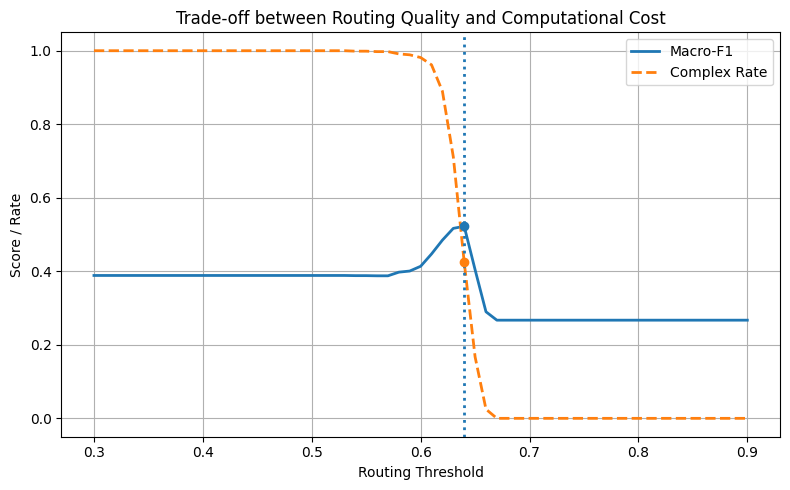

In [ ]:
import matplotlib.pyplot as plt

# unpack curve
ts = [x[0] for x in curve]
complex_rates = [x[1] for x in curve]
macro_f1s = [x[2] for x in curve]

best_t, best_rate, best_f1 = best

plt.figure(figsize=(8, 5))

# macro-F1
plt.plot(ts, macro_f1s, label="Macro-F1", linewidth=2)

# complex rate
plt.plot(ts, complex_rates, label="Complex Rate", linestyle="--", linewidth=2)

# chosen threshold
plt.axvline(best_t, linestyle=":", linewidth=2)
plt.scatter([best_t], [best_f1], zorder=5)
plt.scatter([best_t], [best_rate], zorder=5)

plt.xlabel("Routing Threshold")
plt.ylabel("Score / Rate")
plt.title("Trade-off between Routing Quality and Computational Cost")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


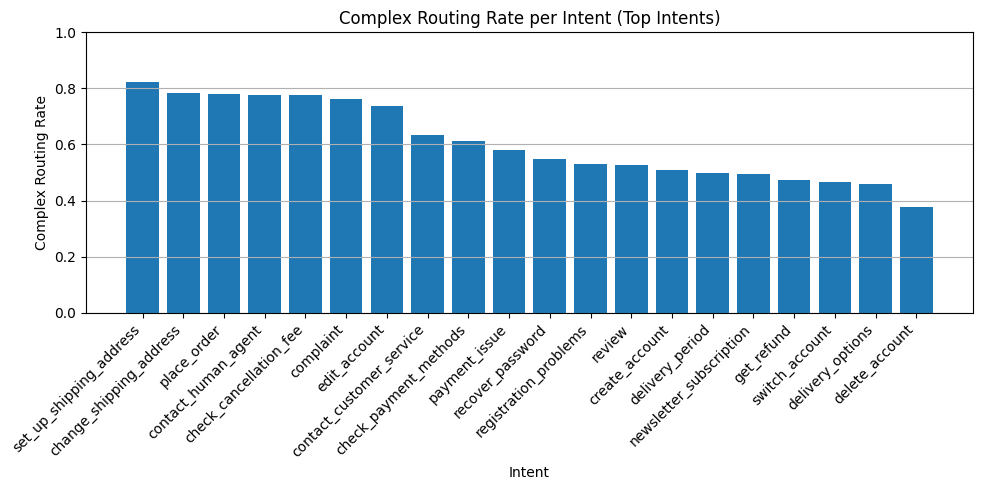

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

# safety: ensure lists
intents = list(eval_i["intent_pred"])
routes = route_eval.astype(int)

# align lengths just in case
n = min(len(intents), len(routes))
intents = intents[:n]
routes = routes[:n]

# compute complex rate per intent
counts = Counter(intents)
complex_counts = defaultdict(int)

for intent, r in zip(intents, routes):
    complex_counts[intent] += r

intent_rates = [
    (intent, complex_counts[intent] / counts[intent])
    for intent in counts
]

# sort by complex rate (descending)
intent_rates.sort(key=lambda x: x[1], reverse=True)

# take top-N for readability (recommended for paper)
TOP_N = 20
intent_rates = intent_rates[:TOP_N]

labels = [x[0] for x in intent_rates]
rates = [x[1] for x in intent_rates]

# plot
plt.figure(figsize=(10, 5))
plt.bar(labels, rates)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Complex Routing Rate")
plt.xlabel("Intent")
plt.title("Complex Routing Rate per Intent (Top Intents)")
plt.ylim(0, 1)
plt.grid(axis="y")

plt.tight_layout()
plt.show()


/tmp/ipython-input-3877518062.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/tmp/ipython-input-3877518062.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/tmp/ipython-input-3877518062.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/tmp/ipython-input-3877518062.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


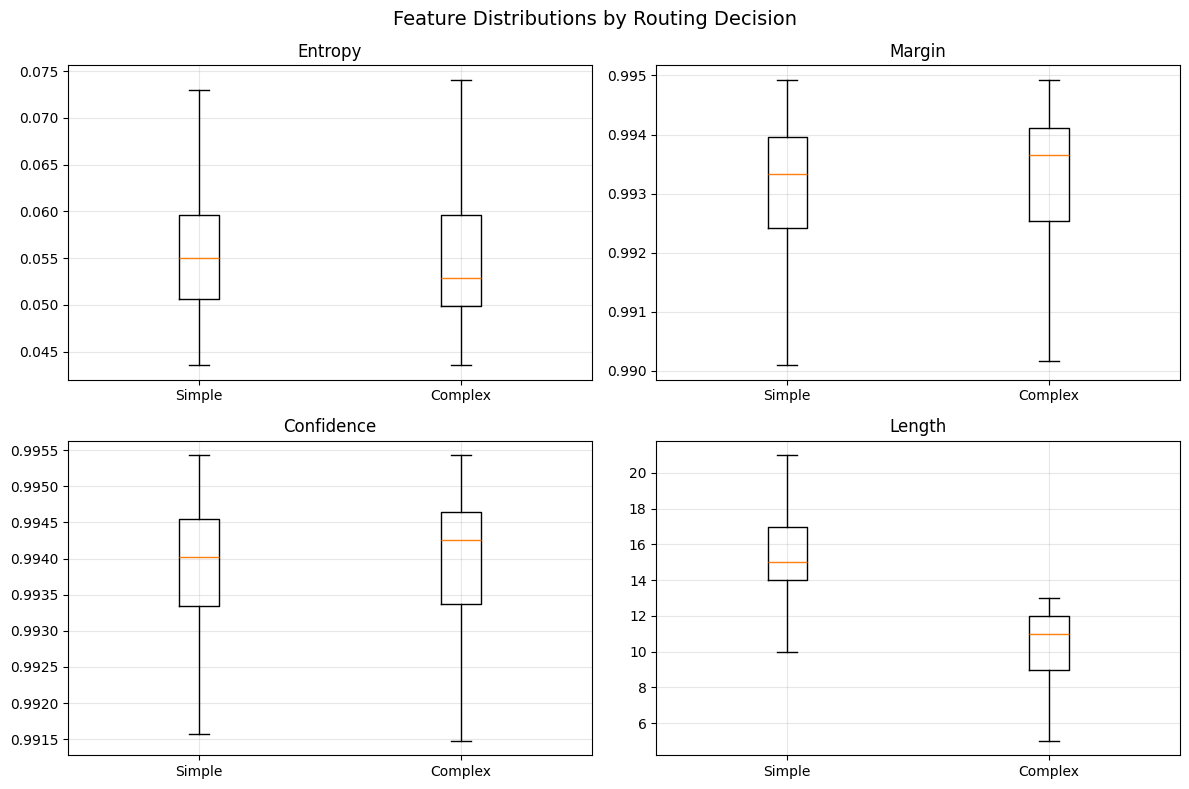

In [ ]:
import matplotlib.pyplot as plt

features = {
    "Entropy": entropy,
    "Margin": margin,
    "Confidence": conf,
    "Length": length
}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, (name, values) in zip(axes, features.items()):
    ax.boxplot(
        [values[route_eval == 0], values[route_eval == 1]],
        labels=["Simple", "Complex"],
        showfliers=False
    )
    ax.set_title(name)
    ax.grid(alpha=0.3)

fig.suptitle("Feature Distributions by Routing Decision", fontsize=14)
plt.tight_layout()
plt.show()
